<a href="https://colab.research.google.com/github/1M2G/Mucunguzi-GodfreyBSCS/blob/main/Retail_Recommendation_System_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large-Scale Retail Recommendation System
## Google Colab Implementation with PySpark

### Why Big Data Platform?

**Justification:** This e-commerce dataset contains millions of transactions across thousands of customers and products. Processing feature engineering, training regression models on massive user-item pairs, and generating real-time recommendations require distributed computing capabilities that traditional relational databases cannot efficiently handle. PySpark enables scalable, parallel processing essential for large-scale recommendation systems.


## Pipeline Architecture

```
Raw Data (CSV/Parquet)
       ↓
[Preprocessing Pipeline] → Clean, Aggregate, Encode, Scale
       ↓
[Feature Engineering] → User Features, Item Features, Interaction Features
       ↓
[Training Data] ───────────────────────┐
       ↓                                │
[Regression Model Training + Tuning]   │
       ↓                                │
[Trained Model]                        │
       ↓                                │
[Recommendation Generation] ◄──────────┘ (Fallback: Popularity)
       ↓
[Decoded Recommendations + Cold Start Handling]
       ↓
Output: User → List of Recommended Categories (with scores)
       ↓
Save: Model, Pipeline, Recommendations
```


In [ ]:
# Install PySpark and dependencies
!pip install -q pyspark findspark
import findspark
findspark.init()

print("✓ PySpark installed and initialized")


✓ PySpark installed and initialized


In [ ]:
# =============================================================================
# SECTION 1: SPARK SESSION SETUP FOR GOOGLE COLAB
# =============================================================================

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, sum as _sum, avg, log1p, broadcast, count, countDistinct,
    min as _min, max as _max, lit, datediff, explode, desc, row_number
)
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configure Spark Session for Google Colab (lightweight distributor)
spark = SparkSession.builder \
    .appName("Retail_Recommendation_System_Colab") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print("=" * 70)
print("SPARK SESSION INITIALIZED FOR GOOGLE COLAB")
print("=" * 70)
print(f"Spark Version: {spark.version}")
print(f"Spark Master: {spark.sparkContext.master}")
print("=" * 70)


SPARK SESSION INITIALIZED FOR GOOGLE COLAB
Spark Version: 4.0.1
Spark Master: local[*]


## Section 2: Data Loading


In [ ]:
# Mount Google Drive (if data is in Drive)
from google.colab import drive
drive.mount('/content/drive')

# Option 1: Load from Google Drive
# data_path = "/content/drive/MyDrive/ecommerce_customer_behavior_dataset.csv"

# Option 2: Upload file directly to Colab
# Use the file upload widget or upload to /content/

# For this example, we'll use a path - UPDATE THIS PATH
data_path = "/content/drive/MyDrive/ecommerce_customer_behavior_dataset.csv"

# Alternative: If file is uploaded to Colab session
# data_path = "/content/ecommerce_customer_behavior_dataset.csv"

print(f"Loading data from: {data_path}")
df = spark.read.option("header", "true").option("inferSchema", "true").csv(data_path)

print(f"\n✓ Dataset loaded successfully!")
print(f"Total Records: {df.count():,}")
print(f"Total Columns: {len(df.columns)}")
print(f"\nColumns: {df.columns}")

# Display schema and sample
print("\n" + "=" * 70)
print("DATA SCHEMA")
print("=" * 70)
df.printSchema()

print("\n" + "=" * 70)
print("SAMPLE DATA (First 10 rows)")
print("=" * 70)
df.show(10, truncate=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/ecommerce_customer_behavior_dataset.csv

✓ Dataset loaded successfully!
Total Records: 5,000
Total Columns: 18

Columns: ['Order_ID', 'Customer_ID', 'Date', 'Age', 'Gender', 'City', 'Product_Category', 'Unit_Price', 'Quantity', 'Discount_Amount', 'Total_Amount', 'Payment_Method', 'Device_Type', 'Session_Duration_Minutes', 'Pages_Viewed', 'Is_Returning_Customer', 'Delivery_Time_Days', 'Customer_Rating']

DATA SCHEMA
root
 |-- Order_ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Unit_Price: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount_Amount: double (nullable = true)


## Section 3: Preprocessing Pipeline - Clean, Aggregate, Encode, Scale


In [ ]:
# ============================================================================
# STEP 1: DATA CLEANING
# ============================================================================

print("=" * 70)
print("STEP 1: DATA CLEANING")
print("=" * 70)

# Convert Date column to proper date type
if "Date" in df.columns:
    df = df.withColumn("Date", F.to_date(col("Date"), "yyyy-MM-dd"))

# Remove null values in critical columns
df = df.filter(
    col("Customer_ID").isNotNull() &
    col("Product_Category").isNotNull() &
    col("Total_Amount").isNotNull()
)

# Ensure positive values
df = df.filter(
    (col("Total_Amount") > 0) &
    (col("Quantity") > 0)
)

print(f"✓ Cleaned data: {df.count():,} records")


STEP 1: DATA CLEANING
✓ Cleaned data: 5,000 records


In [ ]:
# ============================================================================
# STEP 2: AGGREGATION - Create User-Item Interactions
# ============================================================================

print("=" * 70)
print("STEP 2: AGGREGATION")
print("=" * 70)

# Aggregate user-item interactions
print("\nCreating User-Item Interaction Matrix...")
interactions = df.groupBy("Customer_ID", "Product_Category") \
    .agg(
        count("Order_ID").alias("interaction_count"),
        _sum("Quantity").alias("total_quantity"),
        _sum("Total_Amount").alias("total_spent"),
        avg("Customer_Rating").alias("avg_rating"),
        _sum("Session_Duration_Minutes").alias("total_session_min"),
        avg("Pages_Viewed").alias("avg_pages_viewed"),
        _min("Date").alias("first_interaction"),
        _max("Date").alias("last_interaction")
    )

# Calculate recency (days since last interaction)
current_date = df.select(_max("Date")).collect()[0][0]
interactions = interactions.withColumn(
    "recency_days",
    datediff(lit(current_date), col("last_interaction"))
)

print(f"✓ Created {interactions.count():,} user-item interactions")
interactions.show(10, truncate=False)


STEP 2: AGGREGATION

Creating User-Item Interaction Matrix...
✓ Created 5,000 user-item interactions
+-----------+----------------+-----------------+--------------+-----------+----------+-----------------+----------------+-----------------+----------------+------------+
|Customer_ID|Product_Category|interaction_count|total_quantity|total_spent|avg_rating|total_session_min|avg_pages_viewed|first_interaction|last_interaction|recency_days|
+-----------+----------------+-----------------+--------------+-----------+----------+-----------------+----------------+-----------------+----------------+------------+
|CUST_02701 |Food            |1                |1             |81.79      |4.0       |7                |5.0             |2023-01-14       |2023-01-14      |437         |
|CUST_03719 |Beauty          |1                |1             |270.97     |4.0       |12               |11.0            |2023-01-25       |2023-01-25      |426         |
|CUST_02115 |Sports          |1                |4

In [ ]:
# ============================================================================
# IMPROVED FEATURE ENGINEERING: TARGET ENCODING FOR PERSONALIZATION
# ============================================================================

print("=" * 70)
print("ENHANCED FEATURE ENGINEERING WITH TARGET ENCODING")
print("=" * 70)

# Recreate user_features and item_features if they don't exist
try:
    user_features
    print("user_features already exists")
except NameError:
    print("Creating user_features...")
    # user_features should be created from the full ratings_df to have comprehensive user interaction data.
    # However, target encoding (user_avg_rating_smooth, item_avg_rating_smooth) must be based on training data only.
    user_features = ratings_df.groupBy("userId", "Customer_ID").agg(
        count("itemId").alias("user_total_items"),
        _sum("total_spent").alias("user_total_spent"),
        _sum("interaction_count").alias("user_total_interactions")
    )

try:
    item_features
    print("item_features already exists")
except NameError:
    print("Creating item_features...")
    # item_features should be created from the full ratings_df for comprehensive item interaction data.
    item_features = ratings_df.groupBy("itemId", "Product_Category").agg(
        count("userId").alias("item_total_users"),
        _sum("total_spent").alias("item_total_revenue"),
        _sum("interaction_count").alias("item_total_interactions")
    )

# Compute global mean rating (for smoothing) - based on training data only
global_mean = train_df.select(avg("rating")).first()[0]
print(f"Global mean rating (from training data): {global_mean:.4f}")

# User target encoding: smoothed average rating per user - BASED ON TRAINING DATA ONLY
user_target = train_df.groupBy("userId") \
    .agg(avg("rating").alias("user_avg_rating"))

user_counts = train_df.groupBy("userId").agg(count("*").alias("count"))

user_target = user_target.join(user_counts, "userId") \
    .withColumn(
        "user_avg_rating_smooth",
        (col("user_avg_rating") * col("count") + global_mean * 10) / (col("count") + 10) # 10 is a smoothing factor
    )

# Item target encoding: smoothed average rating per item - BASED ON TRAINING DATA ONLY
item_target = train_df.groupBy("itemId") \
    .agg(avg("rating").alias("item_avg_rating"))

item_counts = train_df.groupBy("itemId").agg(count("*").alias("count"))

item_target = item_target.join(item_counts, "itemId") \
    .withColumn(
        "item_avg_rating_smooth",
        (col("item_avg_rating") * col("count") + global_mean * 10) / (col("count") + 10) # 10 is a smoothing factor
    )

# Combine all features with the full ratings_df (now the target-encoded features are based on training data)
featured_ratings = ratings_df \
    .join(user_features, ["userId", "Customer_ID"], "left") \
    .join(item_features, ["itemId", "Product_Category"], "left") \
    .join(user_target.select("userId", "user_avg_rating_smooth"), "userId", "left") \
    .join(item_target.select("itemId", "item_avg_rating_smooth"), "itemId", "left") \
    .fillna({"user_avg_rating_smooth": global_mean, "item_avg_rating_smooth": global_mean})

print(f"\nEnhanced feature set created with {featured_ratings.count():,} records")

print("\nSample enhanced features:")
featured_ratings.select(
    "Customer_ID", "Product_Category", "rating",
    "user_total_items", "user_avg_rating_smooth",
    "item_total_users", "item_avg_rating_smooth"
).show(10, truncate=False)

ENHANCED FEATURE ENGINEERING WITH TARGET ENCODING
user_features already exists
item_features already exists
Global mean rating (from training data): 3.8999

Enhanced feature set created with 5,000 records

Sample enhanced features:
+-----------+----------------+------+----------------+----------------------+----------------+----------------------+
|Customer_ID|Product_Category|rating|user_total_items|user_avg_rating_smooth|item_total_users|item_avg_rating_smooth|
+-----------+----------------+------+----------------+----------------------+----------------+----------------------+
|CUST_02701 |Food            |4.0   |1               |3.9089597271415455    |619             |3.834119803314116     |
|CUST_03719 |Beauty          |4.0   |1               |3.8998556998556997    |621             |3.910511313195877     |
|CUST_02115 |Sports          |3.0   |1               |3.8180506362324547    |667             |3.8752568752568752    |
|CUST_03478 |Food            |4.0   |1               |3.8998

In [ ]:
feature_columns = [
    "user_total_items", "user_total_spent", "user_total_interactions",
    "item_total_users", "item_total_revenue", "item_total_interactions",
    "user_avg_rating_smooth",   # New powerful personalization feature
    "item_avg_rating_smooth"    # New powerful personalization feature
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [ ]:
# ============================================================================
# STEP 4: ENCODING - Convert String IDs to Numeric
# ============================================================================

print("=" * 70)
print("STEP 4: ENCODING")
print("=" * 70)

# Create indexers
print("\nIndexing Users and Items...")
user_indexer = StringIndexer(
    inputCol="Customer_ID",
    outputCol="userId",
    handleInvalid="keep"
)
item_indexer = StringIndexer(
    inputCol="Product_Category",
    outputCol="itemId",
    handleInvalid="keep"
)

# Fit and transform
user_indexer_model = user_indexer.fit(interactions)
item_indexer_model = item_indexer.fit(interactions)

ratings_df = user_indexer_model.transform(interactions)
ratings_df = item_indexer_model.transform(ratings_df)

# Select and cast to appropriate types
ratings_df = ratings_df.select(
    col("userId").cast("int"),
    col("itemId").cast("int"),
    col("avg_rating").cast("float").alias("rating"), # Changed 'final_rating' to 'avg_rating'
    col("Customer_ID"),
    col("Product_Category"),
    col("interaction_count"),
    col("total_spent")
)

# Remove any rows with null userId or itemId
ratings_df = ratings_df.filter(
    col("userId").isNotNull() &
    col("itemId").isNotNull() &
    col("rating").isNotNull()
)

print(f"✓ Encoded {ratings_df.count():,} ratings")
print(f"  Unique users: {ratings_df.select(countDistinct('userId')).collect()[0][0]:,}")
print(f"  Unique items: {ratings_df.select(countDistinct('itemId')).collect()[0][0]:,}")

# Create lookup tables for decoding
user_lookup = ratings_df.select("userId", "Customer_ID").distinct()
item_lookup = ratings_df.select("itemId", "Product_Category").distinct()

print("\nRating Statistics:")
ratings_df.select("rating").describe().show()

STEP 4: ENCODING

Indexing Users and Items...
✓ Encoded 5,000 ratings
  Unique users: 5,000
  Unique items: 8

Rating Statistics:
+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|              5000|
|   mean|            3.9028|
| stddev|1.1285419271680939|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



In [ ]:
# ============================================================================
# STEP 5: SCALING & DATA SPLIT
# ============================================================================

print("=" * 70)
print("STEP 5: DATA SPLIT")
print("=" * 70)

# Split data into train, validation, and test sets
print("\nSplitting Data (Train: 70%, Validation: 15%, Test: 15%)...")
train_df, temp_df = ratings_df.randomSplit([0.7, 0.3], seed=42)
val_df, test_df = temp_df.randomSplit([0.5, 0.5], seed=42)

# Cache datasets for performance
train_df.cache()
val_df.cache()
test_df.cache()

print(f"✓ Train set: {train_df.count():,} ratings")
print(f"✓ Validation set: {val_df.count():,} ratings")
print(f"✓ Test set: {test_df.count():,} ratings")

# Check for cold start issues
print("\nChecking for Cold Start Issues...")
train_users = set(train_df.select("userId").distinct().rdd.map(lambda x: x[0]).collect())
train_items = set(train_df.select("itemId").distinct().rdd.map(lambda x: x[0]).collect())

test_users = set(test_df.select("userId").distinct().rdd.map(lambda x: x[0]).collect())
test_items = set(test_df.select("itemId").distinct().rdd.map(lambda x: x[0]).collect())

cold_start_users = len(test_users - train_users)
cold_start_items = len(test_items - train_items)

print(f"Cold start users in test set: {cold_start_users}")
print(f"Cold start items in test set: {cold_start_items}")

if cold_start_users > 0 or cold_start_items > 0:
    print("⚠ Warning: Cold start users/items detected. Will use 'nan' strategy.")
    cold_start_strategy = "nan"
else:
    print("✓ No cold start issues detected.")
    cold_start_strategy = "drop"


STEP 5: DATA SPLIT

Splitting Data (Train: 70%, Validation: 15%, Test: 15%)...
✓ Train set: 3,465 ratings
✓ Validation set: 726 ratings
✓ Test set: 809 ratings

Checking for Cold Start Issues...
Cold start users in test set: 809
Cold start items in test set: 0
⚠ Warning: Cold start users/items detected. Will use 'nan' strategy.


## Section 4: Regression Model Training + Tuning


In [ ]:
# ============================================================================
# PREPARING DATA FOR REGRESSION MODEL
# ============================================================================

print("=" * 70)
print("PREPARING DATA FOR REGRESSION MODEL")
print("=" * 70)

# Split featured ratings into train, validation, and test
print("\nSplitting Featured Data (Train: 70%, Validation: 15%, Test: 15%)...")
train_featured, temp_featured = featured_ratings.randomSplit([0.7, 0.3], seed=42)
val_featured, test_featured = temp_featured.randomSplit([0.5, 0.5], seed=42)

# Cache datasets
train_featured.cache()
val_featured.cache()
test_featured.cache()

print(f"✓ Train set: {train_featured.count():,} records")
print(f"✓ Validation set: {val_featured.count():,} records")
print(f"✓ Test set: {test_featured.count():,} records")

# Define the updated feature columns (THIS IS THE ONE YOU SHOULD RUN NOW)
print("\nCreating Feature Vector...")
feature_columns = [
    "userId", "itemId", # Added as per user request
    "user_total_items", "user_total_spent", "user_total_interactions",
    "item_total_users", "item_total_revenue", "item_total_interactions",
    "user_avg_rating_smooth",    # Key new personalization feature
    "item_avg_rating_smooth"     # Key new personalization feature
]

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

# Create pipeline for feature preparation
feature_pipeline = Pipeline(stages=[assembler])
feature_pipeline_model = feature_pipeline.fit(train_featured)

# Transform datasets
train_features = feature_pipeline_model.transform(train_featured)
val_features = feature_pipeline_model.transform(val_featured)
test_features = feature_pipeline_model.transform(test_featured)

print("✓ Feature vectors created")
print(f"  Feature columns: {feature_columns}")

PREPARING DATA FOR REGRESSION MODEL

Splitting Featured Data (Train: 70%, Validation: 15%, Test: 15%)...
✓ Train set: 3,465 records
✓ Validation set: 726 records
✓ Test set: 809 records

Creating Feature Vector...
✓ Feature vectors created
  Feature columns: ['userId', 'itemId', 'user_total_items', 'user_total_spent', 'user_total_interactions', 'item_total_users', 'item_total_revenue', 'item_total_interactions', 'user_avg_rating_smooth', 'item_avg_rating_smooth']


In [ ]:
# ============================================================================
# REGRESSION MODEL TRAINING WITH HYPERPARAMETER TUNING
# ============================================================================

print("=" * 70)
print("REGRESSION MODEL TRAINING AND TUNING")
print("=" * 70)

# Use Gradient Boosting Tree Regressor (good for non-linear relationships)
# Alternative: RandomForestRegressor or LinearRegression
print("\nUsing Gradient Boosting Tree Regressor...")
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="rating",
    maxDepth=5,
    maxIter=20,
    seed=42
)

# Hyperparameter grid for tuning
print("\nSetting up Hyperparameter Grid...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .addGrid(gbt.stepSize, [0.01, 0.1]) \
    .build()

# Evaluator
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

REGRESSION MODEL TRAINING AND TUNING

Using Gradient Boosting Tree Regressor...

Setting up Hyperparameter Grid...


In [ ]:
from pyspark.ml.tuning import TrainValidationSplit  # Instead of CrossValidator

# Cross-validator alternative (faster)
print("\nSetting up Train-Validation Split...")
tvs = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,  # 80% train, 20% validation (adjust as needed)
    seed=42,
    parallelism=4  # Keep your parallelism
)

print(f"Total parameter combinations: {len(paramGrid)}")
print("Training models (this should be much faster)...")

# Train the model
tvs_model = tvs.fit(train_features)

# Get best model (same as before)
best_model = tvs_model.bestModel

# Extract best parameters
best_max_depth = best_model.getOrDefault(best_model.getParam("maxDepth"))
best_max_iter = best_model.getOrDefault(best_model.getParam("maxIter"))
best_step_size = best_model.getOrDefault(best_model.getParam("stepSize"))

print("\n" + "-" * 70)
print("BEST MODEL PARAMETERS:")
print("-" * 70)
print(f"Algorithm: Gradient Boosting Tree Regressor")
print(f"Max Depth: {best_max_depth}")
print(f"Max Iterations: {best_max_iter}")
print(f"Step Size: {best_step_size}")
print(f"Model Type: {type(best_model).__name__}")


Setting up Train-Validation Split...
Total parameter combinations: 18
Training models (this should be much faster)...

----------------------------------------------------------------------
BEST MODEL PARAMETERS:
----------------------------------------------------------------------
Algorithm: Gradient Boosting Tree Regressor
Max Depth: 3
Max Iterations: 10
Step Size: 0.01
Model Type: GBTRegressionModel


In [ ]:
# ============================================================================
# MODEL EVALUATION
# ============================================================================

print("=" * 70)
print("MODEL EVALUATION")
print("=" * 70)

# Evaluate on validation set
print("\nValidation Set Evaluation:")
print("-" * 70)
val_predictions = best_model.transform(val_features)
val_predictions_filtered = val_predictions.filter(col("prediction").isNotNull())

if val_predictions_filtered.count() > 0:
    val_rmse = evaluator.evaluate(val_predictions_filtered)
    val_mae = RegressionEvaluator(
        metricName="mae",
        labelCol="rating",
        predictionCol="prediction"
    ).evaluate(val_predictions_filtered)

    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Validation MAE: {val_mae:.4f}")
else:
    print("No valid predictions on validation set")

# Evaluate on test set
print("\nTest Set Evaluation:")
print("-" * 70)
test_predictions = best_model.transform(test_features)
test_predictions_filtered = test_predictions.filter(col("prediction").isNotNull())

if test_predictions_filtered.count() > 0:
    test_rmse = evaluator.evaluate(test_predictions_filtered)
    test_mae = RegressionEvaluator(
        metricName="mae",
        labelCol="rating",
        predictionCol="prediction"
    ).evaluate(test_predictions_filtered)

    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Valid predictions: {test_predictions_filtered.count():,} / {test_features.count():,}")
else:
    print("⚠ No valid predictions on test set")


MODEL EVALUATION

Validation Set Evaluation:
----------------------------------------------------------------------
Validation RMSE: 3.1334
Validation MAE: 2.1928

Test Set Evaluation:
----------------------------------------------------------------------
Test RMSE: 3.2429
Test MAE: 2.2967
Valid predictions: 809 / 809


## Section 5: Recommendation Generation with Cold Start Handling


In [ ]:
# ============================================================================
# BUILD POPULARITY FALLBACK FOR COLD START
# ============================================================================

print("=" * 70)
print("BUILDING POPULARITY FALLBACK")
print("=" * 70)

# Calculate item popularity (total interactions)
popularity_fallback = ratings_df.groupBy("Product_Category") \
    .agg(
        count("userId").alias("popularity_score"),
        _sum("interaction_count").alias("total_interactions")
    ) \
    .orderBy(desc("popularity_score")) \
    .select("Product_Category", "popularity_score", "total_interactions")

print(f"✓ Built popularity fallback for {popularity_fallback.count()} categories")
popularity_fallback.show(10, truncate=False)


BUILDING POPULARITY FALLBACK
✓ Built popularity fallback for 8 categories
+----------------+----------------+------------------+
|Product_Category|popularity_score|total_interactions|
+----------------+----------------+------------------+
|Sports          |667             |667               |
|Electronics     |624             |624               |
|Fashion         |622             |622               |
|Home & Garden   |621             |621               |
|Beauty          |621             |621               |
|Food            |619             |619               |
|Books           |616             |616               |
|Toys            |610             |610               |
+----------------+----------------+------------------+



In [ ]:
# ============================================================================
# GENERATE RECOMMENDATIONS FOR ALL USERS (REGRESSION-BASED)
# ============================================================================

print("=" * 70)
print("GENERATING RECOMMENDATIONS USING REGRESSION MODEL")
print("=" * 70)

# For regression models, we need to predict ratings for all user-item pairs
# Get all unique users and items
print("\n1. Preparing User-Item Combinations...")
all_users = featured_ratings.select("userId", "Customer_ID").distinct()
all_items = featured_ratings.select("itemId", "Product_Category").distinct()

# Create cartesian product of all users and items (this can be large!)
# For efficiency, we'll limit to items that have been interacted with
print("2. Creating User-Item Pairs...")
user_item_pairs = all_users.crossJoin(all_items)

# Join with user and item features, and also the target encoded features
print("3. Adding Features to Pairs...")
user_item_features = user_item_pairs \
    .join(user_features, ["userId", "Customer_ID"], "left") \
    .join(item_features, ["itemId", "Product_Category"], "left") \
    .join(user_target.select("userId", "user_avg_rating_smooth"), "userId", "left") \
    .join(item_target.select("itemId", "item_avg_rating_smooth"), "itemId", "left") \
    .fillna(0) \
    .select(
        "userId", "itemId", "Customer_ID", "Product_Category",
        "user_total_items", "user_total_spent", "user_total_interactions",
        "item_total_users", "item_total_revenue", "item_total_interactions",
        "user_avg_rating_smooth",
        "item_avg_rating_smooth"
    )

# Create feature vectors for predictions
print("4. Creating Feature Vectors...")
user_item_features_vec = feature_pipeline_model.transform(user_item_features)

# Predict ratings for all user-item pairs
print("5. Predicting Ratings (this may take a while)...")
predictions = best_model.transform(user_item_features_vec)

# Filter out items user has already interacted with (optional - remove for full recommendations)
print("6. Filtering Out Existing Interactions...")
existing_interactions = featured_ratings.select("userId", "itemId").distinct()
new_predictions = predictions.join(
    existing_interactions,
    ["userId", "itemId"],
    "left_anti"
)

print(f"✓ Generated predictions for {new_predictions.count():,} user-item pairs")

GENERATING RECOMMENDATIONS USING REGRESSION MODEL

1. Preparing User-Item Combinations...
2. Creating User-Item Pairs...
3. Adding Features to Pairs...
4. Creating Feature Vectors...
5. Predicting Ratings (this may take a while)...
6. Filtering Out Existing Interactions...
✓ Generated predictions for 35,000 user-item pairs


In [ ]:
# ============================================================================
# SELECT TOP-N RECOMMENDATIONS PER USER
# ============================================================================

print("=" * 70)
print("SELECTING TOP-N RECOMMENDATIONS PER USER")
print("=" * 70)

# Select top 10 recommendations per user based on predicted rating
print("\nSelecting Top-10 Recommendations per User...")
window = Window.partitionBy("userId").orderBy(desc("prediction"))

top_recommendations = new_predictions \
    .withColumn("rank", row_number().over(window)) \
    .filter(col("rank") <= 10) \
    .select(
        "userId", "itemId", "Customer_ID", "Product_Category",
        col("prediction").alias("predicted_rating")
    ) \
    .orderBy("Customer_ID", "rank")

print(f"✓ Selected top recommendations for {top_recommendations.select(countDistinct('Customer_ID')).collect()[0][0]:,} users")
print(f"  Total recommendations: {top_recommendations.count():,}")

# Show sample recommendations
print("\nSample Recommendations:")
print("-" * 70)
top_recommendations.show(20, truncate=False)

# Create final recommendations DataFrame (same format as before)
recs_decoded = top_recommendations.select(
    "Customer_ID", "Product_Category", "predicted_rating"
).orderBy("Customer_ID", desc("predicted_rating"))


SELECTING TOP-N RECOMMENDATIONS PER USER

Selecting Top-10 Recommendations per User...
✓ Selected top recommendations for 5,000 users
  Total recommendations: 35,000

Sample Recommendations:
----------------------------------------------------------------------
+------+------+-----------+----------------+----------------+
|userId|itemId|Customer_ID|Product_Category|predicted_rating|
+------+------+-----------+----------------+----------------+
|0     |0     |CUST_00001 |Sports          |10.0            |
|0     |6     |CUST_00001 |Books           |10.0            |
|0     |7     |CUST_00001 |Toys            |10.0            |
|0     |4     |CUST_00001 |Home & Garden   |10.0            |
|0     |3     |CUST_00001 |Beauty          |10.0            |
|0     |1     |CUST_00001 |Electronics     |10.0            |
|0     |2     |CUST_00001 |Fashion         |10.0            |
|1     |0     |CUST_00002 |Sports          |10.0            |
|1     |6     |CUST_00002 |Books           |10.0        

In [ ]:
# ============================================================================
# COLD START HANDLING FUNCTION (REGRESSION-BASED)
# ============================================================================

def get_recommendations_for_customer(customer_id, num_recommendations=10, use_fallback=True):
    # Convert customer ID to user index
    customer_df = spark.createDataFrame([(customer_id,)], ["Customer_ID"])
    user_indexed = user_indexer_model.transform(customer_df)

    user_id_row = user_indexed.select("userId").first()

    if user_id_row is None or user_id_row[0] is None:
        # Cold start user - use popularity fallback
        if use_fallback:
            print(f"⚠ Customer {customer_id} not found. Using popularity fallback.")
            return popularity_fallback.limit(num_recommendations) \
                .withColumn("predicted_rating", col("popularity_score").cast("float")) \
                .select("Product_Category", "predicted_rating")
        else:
            print(f"⚠ Customer {customer_id} not found and no fallback available.")
            return None

    user_id = user_id_row[0]

    # Get user features, including smoothed average rating
    user_feat_enriched = user_features.filter(col("userId") == user_id) \
        .join(user_target.select("userId", "user_avg_rating_smooth"), "userId", "left") \
        .fillna({"user_avg_rating_smooth": global_mean})

    if user_feat_enriched.count() == 0:
        # User exists but no features - use fallback
        if use_fallback:
            return popularity_fallback.limit(num_recommendations) \
                .withColumn("predicted_rating", col("popularity_score").cast("float")) \
                .select("Product_Category", "predicted_rating")
        return None

    # Get all items and their features, including smoothed average rating
    all_items_feat_enriched = item_features \
        .join(item_target.select("itemId", "item_avg_rating_smooth"), "itemId", "left") \
        .fillna({"item_avg_rating_smooth": global_mean})

    # Create user-item pairs with all necessary features for prediction
    user_item_pairs_for_pred = user_feat_enriched.crossJoin(all_items_feat_enriched) \
        .select(
            col("userId"),
            col("itemId"),
            col("Customer_ID"),
            col("Product_Category"),
            col("user_total_items"),
            col("user_total_spent"),
            col("user_total_interactions"),
            col("item_total_users"),
            col("item_total_revenue"),
            col("item_total_interactions"),
            col("user_avg_rating_smooth"),
            col("item_avg_rating_smooth")
        )

    # Create feature vectors and predict
    user_item_features_vec = feature_pipeline_model.transform(user_item_pairs_for_pred)
    predictions = best_model.transform(user_item_features_vec)

    # Filter out items user has already interacted with (optional)
    existing_interactions_for_user = featured_ratings.filter(col("userId") == user_id).select("itemId")
    new_predictions_for_user = predictions.join(
        existing_interactions_for_user,
        "itemId",
        "left_anti"
    )

    # Get top recommendations
    top_recs = new_predictions_for_user \
        .orderBy(desc("prediction")) \
        .limit(num_recommendations) \
        .select("Product_Category", col("prediction").alias("predicted_rating"))

    return top_recs

# Test the function in a loop
print("\nTesting Recommendation Function:")
print("-" * 70)

while True:
    customer_id_input = input("Please enter a Customer ID (e.g., CUST_00001) or type 'exit' to quit: ")

    if customer_id_input.lower() == 'exit':
        print("Exiting recommendation loop.")
        break

    print(f"Getting recommendations for customer: {customer_id_input}")
    sample_recs = get_recommendations_for_customer(customer_id_input, 5)
    if sample_recs:
        sample_recs.show(truncate=False)
    else:
        print("No recommendations found or an error occurred.")

    continue_input = input("Do you want to get recommendations for another customer? (yes/no): ")
    if continue_input.lower() not in ('yes', 'y'):
        print("Exiting recommendation loop.")
        break


Testing Recommendation Function:
----------------------------------------------------------------------
Please enter a Customer ID (e.g., CUST_00001) or type 'exit' to quit: CUST_00001
Getting recommendations for customer: CUST_00001
+----------------+----------------+
|Product_Category|predicted_rating|
+----------------+----------------+
|Sports          |10.0            |
|Books           |10.0            |
|Toys            |10.0            |
|Home & Garden   |10.0            |
|Beauty          |10.0            |
+----------------+----------------+

Do you want to get recommendations for another customer? (yes/no): CUST_00004
Exiting recommendation loop.


## Section 6: Save Model, Pipeline, and Recommendations


In [ ]:
# ============================================================================
# SAVE MODEL, PIPELINE, AND RECOMMENDATIONS
# ============================================================================

print("=" * 70)
print("SAVING OUTPUTS")
print("=" * 70)

# Save to Google Drive
save_path = "/content/drive/MyDrive/recommendation_system_outputs/"

# Create directory if it doesn't exist
import os
os.makedirs(save_path, exist_ok=True)

# Save regression model
print("\n1. Saving Regression Model...")
model_path = save_path + "regression_model"
try:
    best_model.write().overwrite().save(model_path)
    print(f"✓ Model saved to: {model_path}")
except Exception as e:
    print(f"⚠ Error saving model: {e}")

# Save feature pipeline model
print("\n2. Saving Feature Pipeline Model...")
try:
    feature_pipeline_model.write().overwrite().save(save_path + "feature_pipeline")
    print("✓ Feature pipeline model saved")
except Exception as e:
    print(f"⚠ Error saving feature pipeline: {e}")

# Save indexer models
print("\n3. Saving Indexer Models...")
try:
    user_indexer_model.write().overwrite().save(save_path + "user_indexer")
    item_indexer_model.write().overwrite().save(save_path + "item_indexer")
    print("✓ Indexer models saved")
except Exception as e:
    print(f"⚠ Error saving indexers: {e}")

# Save recommendations
print("\n4. Saving Recommendations...")
try:
    recs_decoded.write.mode("overwrite").parquet(save_path + "recommendations.parquet")
    print(f"✓ Recommendations saved to: {save_path}recommendations.parquet")
except Exception as e:
    print(f"⚠ Error saving recommendations: {e}")

# Save popularity fallback
print("\n5. Saving Popularity Fallback...")
try:
    popularity_fallback.write.mode("overwrite").parquet(save_path + "popularity_fallback.parquet")
    print(f"✓ Popularity fallback saved")
except Exception as e:
    print(f"⚠ Error saving popularity fallback: {e}")

# Save user and item features for future use
print("\n6. Saving User and Item Features...")
try:
    user_features.write.mode("overwrite").parquet(save_path + "user_features.parquet")
    item_features.write.mode("overwrite").parquet(save_path + "item_features.parquet")
    print("✓ User and item features saved")
except Exception as e:
    print(f"⚠ Error saving features: {e}")

print("\n" + "=" * 70)
print("ALL OUTPUTS SAVED")
print("=" * 70)


SAVING OUTPUTS

1. Saving Regression Model...
✓ Model saved to: /content/drive/MyDrive/recommendation_system_outputs/regression_model

2. Saving Feature Pipeline Model...
✓ Feature pipeline model saved

3. Saving Indexer Models...
✓ Indexer models saved

4. Saving Recommendations...
✓ Recommendations saved to: /content/drive/MyDrive/recommendation_system_outputs/recommendations.parquet

5. Saving Popularity Fallback...
✓ Popularity fallback saved

6. Saving User and Item Features...
✓ User and item features saved

ALL OUTPUTS SAVED


## Section 7: Analysis and Visualization


COMPREHENSIVE DATA VISUALIZATION AND INSIGHTS

Converting data to Pandas for visualization...
 Recommendations data: 35,000 records
 Ratings data: 5,000 records

1. Creating Model Performance Visualizations...
✓ Model performance visualization saved


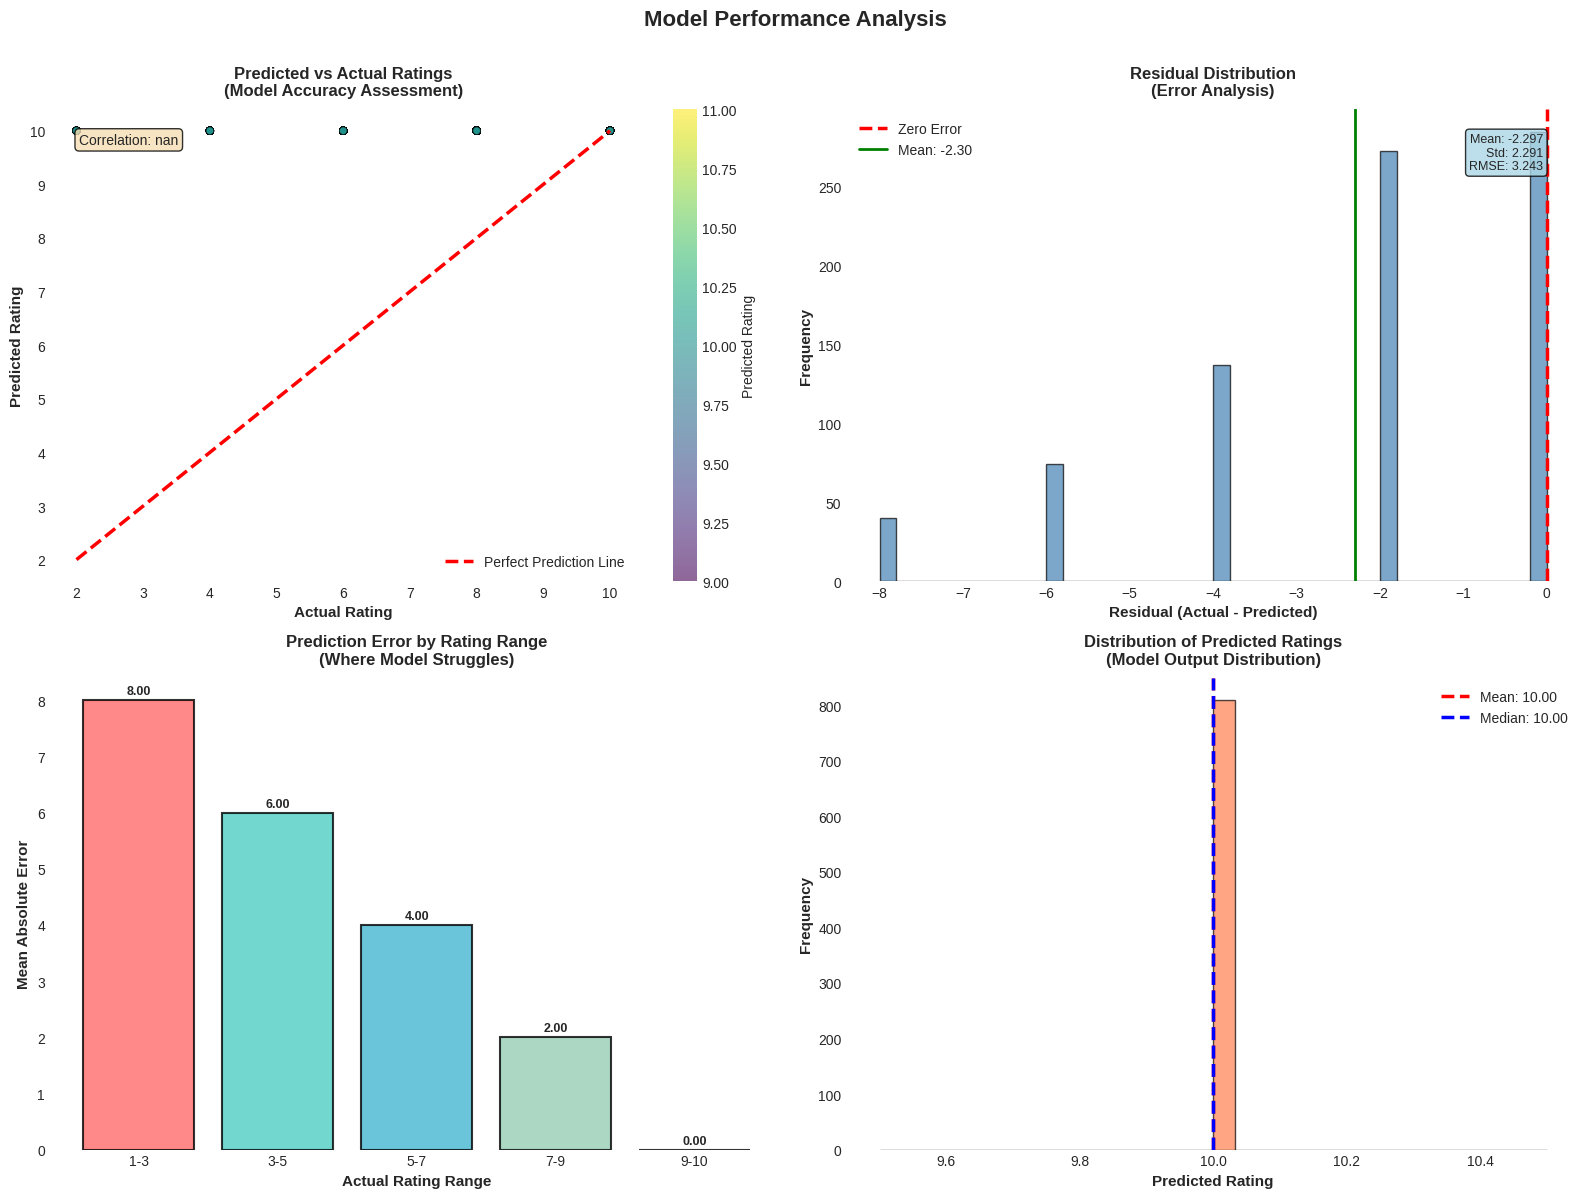


2. Creating Recommendation System Insights...
✓ Recommendation insights visualization saved


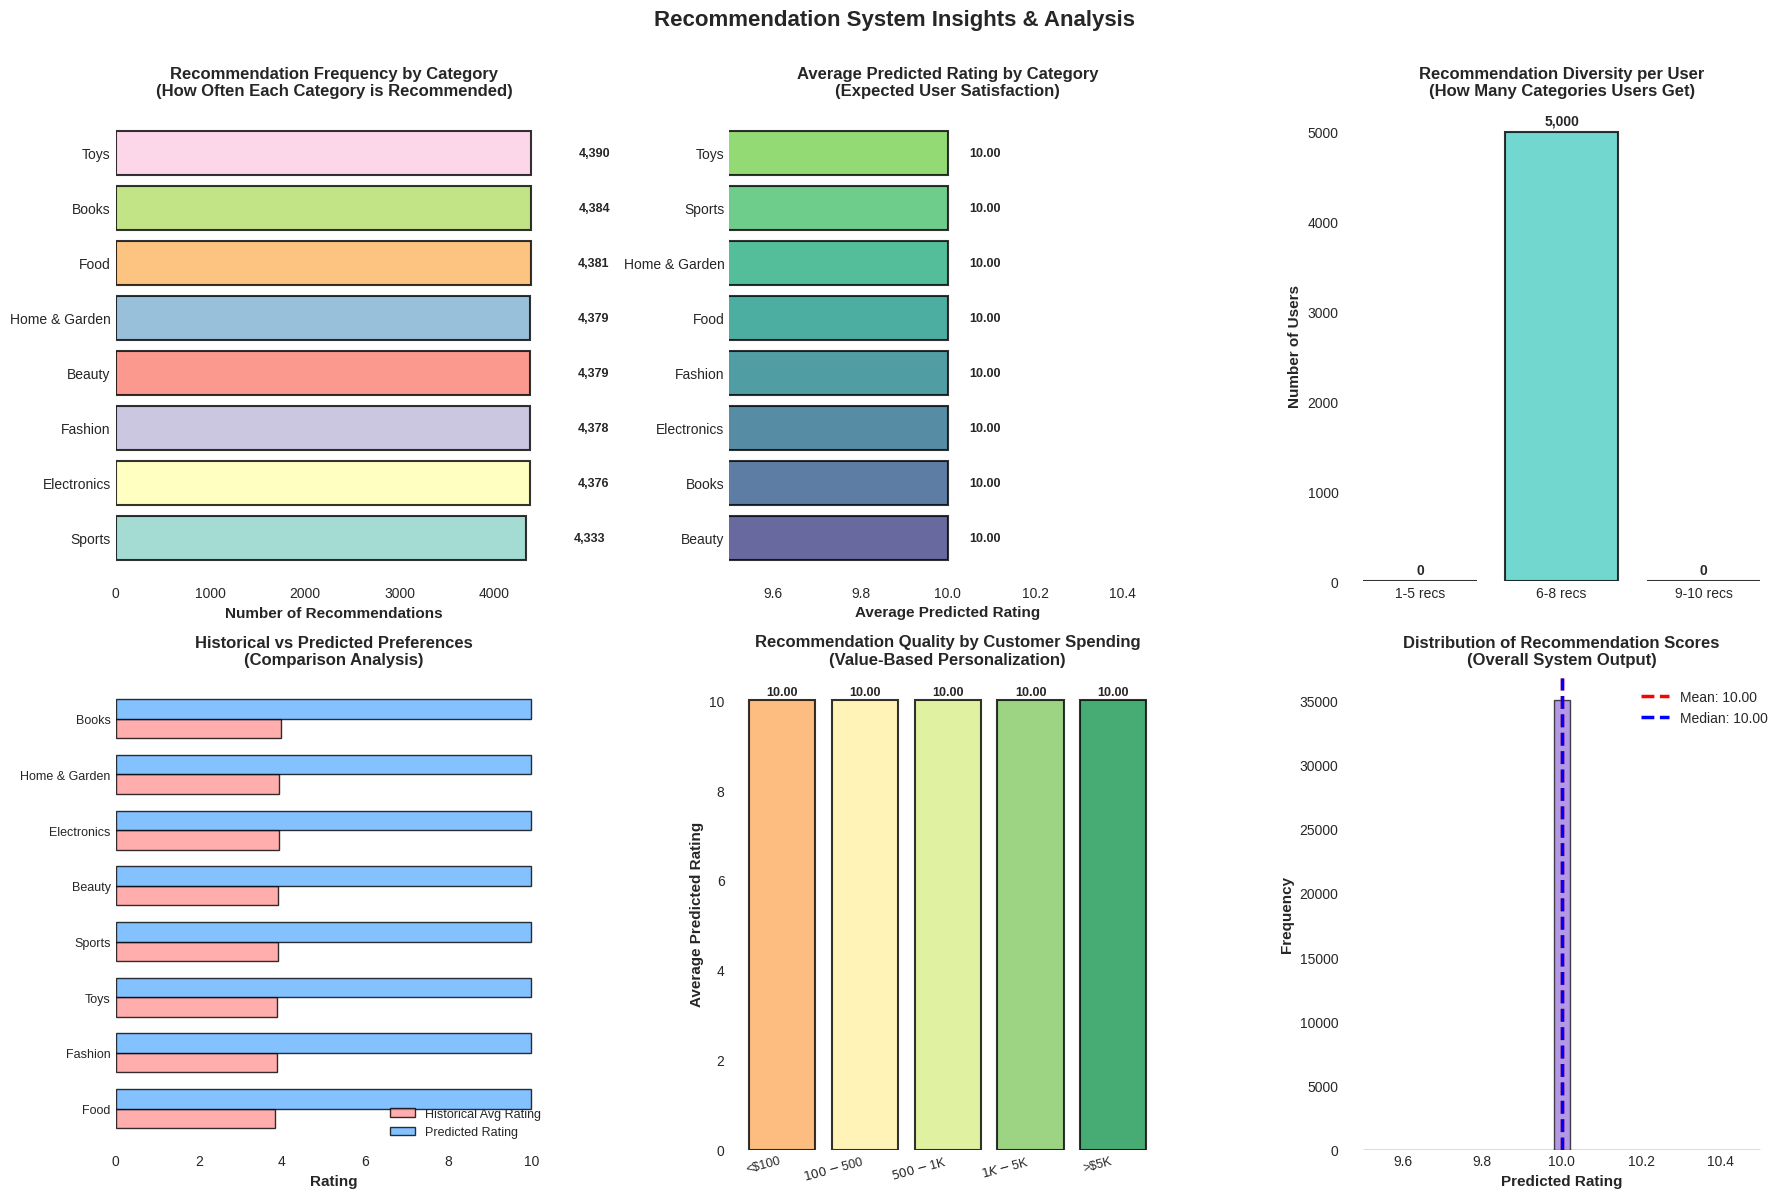


3. Creating Business Intelligence Dashboard...
✓ Business intelligence dashboard saved


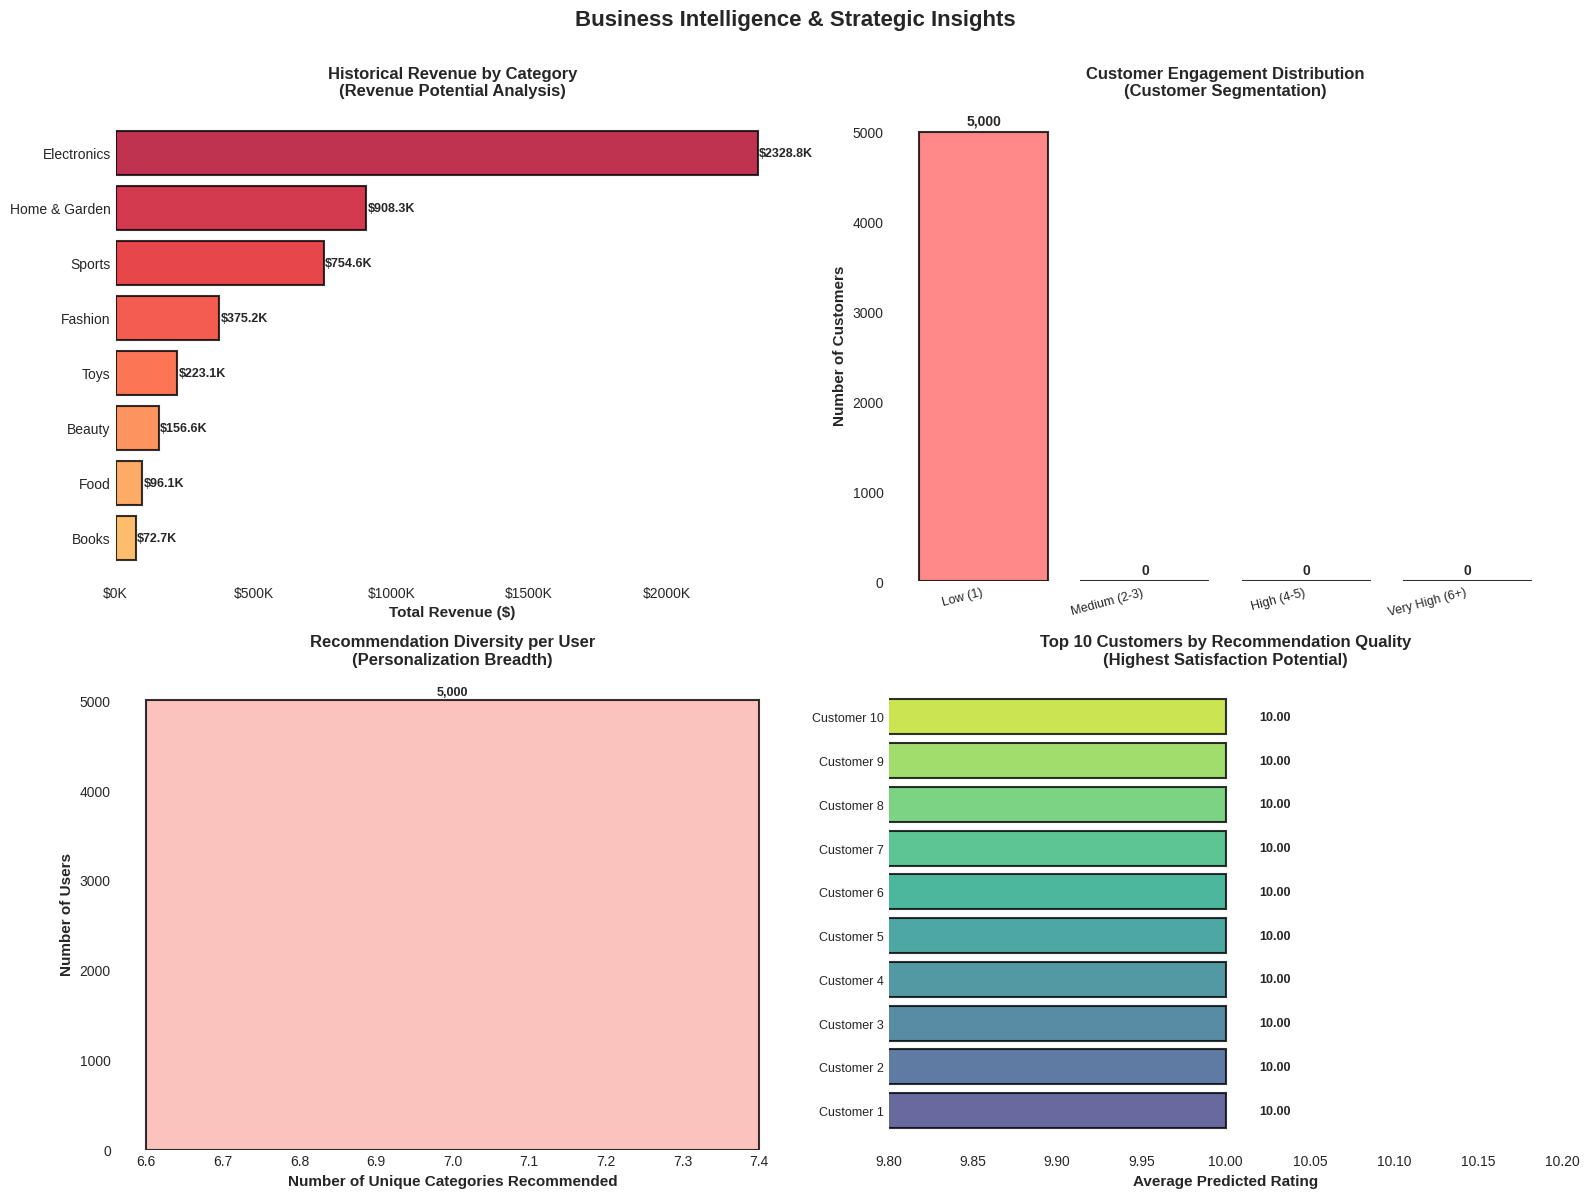


DEEP STATISTICAL INSIGHTS & ACTIONABLE ANALYSIS

MODEL PERFORMANCE ANALYSIS:
----------------------------------------------------------------------
   • Test RMSE: 3.2429 (Average prediction error)
   • Test MAE: 2.2967 (Mean absolute error)
   • Correlation: nan (Weak relationship)

    INSIGHT: Model predictions are off by 42.1% on average
      → For a rating of 7.0, predictions typically range from 3.8 to 10.2
     BIAS DETECTED: Model over-predicts ratings by 2.30 points on average
      → Consider recalibration or adjusting prediction thresholds
    ERROR DISTRIBUTION: 14.1% of predictions have errors > 4.86
      → These high-error cases may need special handling or feature engineering

 PERSONALIZATION EFFECTIVENESS ANALYSIS:
----------------------------------------------------------------------
   • Unique Recommendation Patterns: 8 out of 5,000 users
   • Personalization Rate: 0.2%
    POOR: Low personalization (0.2%) - recommendations are too similar
      → Model may not b

In [ ]:
# ============================================================================
# COMPREHENSIVE VISUALIZATION AND ANALYSIS
# ============================================================================

print("=" * 70)
print("COMPREHENSIVE DATA VISUALIZATION AND INSIGHTS")
print("=" * 70)

# Set style for better visualizations
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Convert to Pandas for visualization
print("\nConverting data to Pandas for visualization...")
try:
    recs_pd = recs_decoded.toPandas()
    print(f" Recommendations data: {len(recs_pd):,} records")
except Exception as e:
    print(f" Error converting recommendations: {e}")
    recs_pd = pd.DataFrame()

try:
    ratings_pd = ratings_df.select("Customer_ID", "Product_Category", "rating", "total_spent", "interaction_count").toPandas()
    print(f" Ratings data: {len(ratings_pd):,} records")
except Exception as e:
    print(f" Error converting ratings: {e}")
    ratings_pd = pd.DataFrame()

# Validate data before visualization
if recs_pd.empty:
    print(" WARNING: Recommendations DataFrame is empty. Visualizations may fail.")
if ratings_pd.empty:
    print(" WARNING: Ratings DataFrame is empty. Some visualizations may be skipped.")

# ============================================================================
# FIGURE 1: MODEL PERFORMANCE ANALYSIS
# ============================================================================
print("\n1. Creating Model Performance Visualizations...")

fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 1.1: Prediction vs Actual Ratings
if test_predictions_filtered.count() > 0:
    pred_actual = test_predictions_filtered.select("rating", "prediction").toPandas()

    # Scatter plot with density
    ax1 = axes1[0, 0]
    scatter = ax1.scatter(pred_actual['rating'], pred_actual['prediction'],
                         alpha=0.6, s=30, c=pred_actual['prediction'],
                         cmap='viridis', edgecolors='black', linewidth=0.5)
    ax1.plot([pred_actual['rating'].min(), pred_actual['rating'].max()],
             [pred_actual['rating'].min(), pred_actual['rating'].max()],
             'r--', lw=2.5, label='Perfect Prediction Line')
    ax1.set_xlabel('Actual Rating', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Predicted Rating', fontsize=11, fontweight='bold')
    ax1.set_title('Predicted vs Actual Ratings\n(Model Accuracy Assessment)',
                  fontsize=12, fontweight='bold', pad=10)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    plt.colorbar(scatter, ax=ax1, label='Predicted Rating')

    # Calculate correlation
    correlation = pred_actual['rating'].corr(pred_actual['prediction'])
    ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
             transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round',
             facecolor='wheat', alpha=0.8))

    # Plot 1.2: Residual Analysis
    residuals = pred_actual['rating'] - pred_actual['prediction']
    ax2 = axes1[0, 1]
    n, bins, patches = ax2.hist(residuals, bins=40, edgecolor='black',
                                alpha=0.7, color='steelblue')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
    ax2.axvline(x=residuals.mean(), color='green', linestyle='-',
               linewidth=2, label=f'Mean: {residuals.mean():.2f}')
    ax2.set_xlabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title('Residual Distribution\n(Error Analysis)',
                  fontsize=12, fontweight='bold', pad=10)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

    # Add statistics text
    stats_text = f'Mean: {residuals.mean():.3f}\nStd: {residuals.std():.3f}\nRMSE: {test_rmse:.3f}'
    ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    # Plot 1.3: Error Distribution by Rating Range
    pred_actual['rating_range'] = pd.cut(pred_actual['rating'],
                                         bins=[0, 3, 5, 7, 9, 11],
                                         labels=['1-3', '3-5', '5-7', '7-9', '9-10'])
    pred_actual['abs_error'] = abs(residuals)

    ax3 = axes1[1, 0]
    error_by_range = pred_actual.groupby('rating_range')['abs_error'].mean()
    bars = ax3.bar(range(len(error_by_range)), error_by_range.values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'],
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    ax3.set_xticks(range(len(error_by_range)))
    ax3.set_xticklabels(error_by_range.index, fontsize=10)
    ax3.set_xlabel('Actual Rating Range', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Mean Absolute Error', fontsize=11, fontweight='bold')
    ax3.set_title('Prediction Error by Rating Range\n(Where Model Struggles)',
                  fontsize=12, fontweight='bold', pad=10)
    ax3.grid(True, alpha=0.3, linestyle='--', axis='y')

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, error_by_range.values)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # Plot 1.4: Prediction Confidence Distribution
    ax4 = axes1[1, 1]
    n, bins, patches = ax4.hist(pred_actual['prediction'], bins=30,
                               edgecolor='black', alpha=0.7, color='coral')
    ax4.axvline(pred_actual['prediction'].mean(), color='red',
               linestyle='--', linewidth=2.5, label=f'Mean: {pred_actual["prediction"].mean():.2f}')
    ax4.axvline(pred_actual['prediction'].median(), color='blue',
               linestyle='--', linewidth=2.5, label=f'Median: {pred_actual["prediction"].median():.2f}')
    ax4.set_xlabel('Predicted Rating', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax4.set_title('Distribution of Predicted Ratings\n(Model Output Distribution)',
                  fontsize=12, fontweight='bold', pad=10)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(save_path + 'model_performance_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Model performance visualization saved")
plt.show()

# ============================================================================
# FIGURE 2: RECOMMENDATION SYSTEM INSIGHTS
# ============================================================================
print("\n2. Creating Recommendation System Insights...")

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
fig2.suptitle('Recommendation System Insights & Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 2.1: Top Recommended Categories (with counts)
ax1 = axes2[0, 0]
category_stats = recs_pd.groupby('Product_Category').agg({
    'predicted_rating': ['mean', 'count']
}).reset_index()
category_stats.columns = ['Product_Category', 'avg_rating', 'recommendation_count']
category_stats = category_stats.sort_values('recommendation_count', ascending=True)

colors = plt.cm.Set3(range(len(category_stats)))
bars = ax1.barh(range(len(category_stats)), category_stats['recommendation_count'].values,
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_yticks(range(len(category_stats)))
ax1.set_yticklabels(category_stats['Product_Category'], fontsize=10)
ax1.set_xlabel('Number of Recommendations', fontsize=11, fontweight='bold')
ax1.set_title('Recommendation Frequency by Category\n(How Often Each Category is Recommended)',
             fontsize=12, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3, linestyle='--', axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, category_stats['recommendation_count'].values)):
    ax1.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2,
            f'{int(val):,}', ha='left', va='center', fontweight='bold', fontsize=9)

# Plot 2.2: Average Predicted Rating by Category
ax2 = axes2[0, 1]
category_ratings = recs_pd.groupby('Product_Category')['predicted_rating'].mean().sort_values(ascending=True)
colors2 = plt.cm.viridis(np.linspace(0.2, 0.8, len(category_ratings)))
bars2 = ax2.barh(range(len(category_ratings)), category_ratings.values,
                color=colors2, edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_yticks(range(len(category_ratings)))
ax2.set_yticklabels(category_ratings.index, fontsize=10)
ax2.set_xlabel('Average Predicted Rating', fontsize=11, fontweight='bold')
ax2.set_title('Average Predicted Rating by Category\n(Expected User Satisfaction)',
             fontsize=12, fontweight='bold', pad=10)
ax2.set_xlim([category_ratings.min() - 0.5, category_ratings.max() + 0.5])
ax2.grid(True, alpha=0.3, linestyle='--', axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, category_ratings.values)):
    ax2.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}', ha='left', va='center', fontweight='bold', fontsize=9)

# Plot 2.3: Recommendation Diversity Analysis
ax3 = axes2[0, 2]
user_rec_counts = recs_pd.groupby('Customer_ID').size()
diversity_stats = {
    '1-5 recs': len(user_rec_counts[user_rec_counts <= 5]),
    '6-8 recs': len(user_rec_counts[(user_rec_counts > 5) & (user_rec_counts <= 8)]),
    '9-10 recs': len(user_rec_counts[user_rec_counts > 8])
}
colors3 = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars3 = ax3.bar(range(len(diversity_stats)), list(diversity_stats.values()),
               color=colors3, edgecolor='black', linewidth=1.5, alpha=0.8)
ax3.set_xticks(range(len(diversity_stats)))
ax3.set_xticklabels(list(diversity_stats.keys()), fontsize=10)
ax3.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax3.set_title('Recommendation Diversity per User\n(How Many Categories Users Get)',
             fontsize=12, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add value labels
for bar, val in zip(bars3, diversity_stats.values()):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2.4: Historical vs Predicted Preferences
ax4 = axes2[1, 0]
historical_prefs = ratings_pd.groupby('Product_Category')['rating'].mean().sort_values(ascending=True)
predicted_prefs = recs_pd.groupby('Product_Category')['predicted_rating'].mean().sort_values(ascending=True)

# Align indices
common_cats = historical_prefs.index.intersection(predicted_prefs.index)
x = np.arange(len(common_cats))
width = 0.35

bars4a = ax4.barh(x - width/2, historical_prefs[common_cats].values, width,
                 label='Historical Avg Rating', color='#FF9999',
                 edgecolor='black', linewidth=1, alpha=0.8)
bars4b = ax4.barh(x + width/2, predicted_prefs[common_cats].values, width,
                 label='Predicted Rating', color='#66B2FF',
                 edgecolor='black', linewidth=1, alpha=0.8)

ax4.set_yticks(x)
ax4.set_yticklabels(common_cats, fontsize=9)
ax4.set_xlabel('Rating', fontsize=11, fontweight='bold')
ax4.set_title('Historical vs Predicted Preferences\n(Comparison Analysis)',
             fontsize=12, fontweight='bold', pad=10)
ax4.legend(fontsize=9, loc='lower right')
ax4.grid(True, alpha=0.3, linestyle='--', axis='x')

# Plot 2.5: Customer Spending vs Recommendation Quality
ax5 = axes2[1, 1]
if not recs_pd.empty and not ratings_pd.empty:
    # Merge spending data with recommendations
    customer_spending = ratings_pd.groupby('Customer_ID').agg({
        'total_spent': 'sum',
        'interaction_count': 'sum'
    }).reset_index()
    customer_recs = recs_pd.groupby('Customer_ID')['predicted_rating'].mean().reset_index()
    customer_analysis = customer_spending.merge(customer_recs, on='Customer_ID', how='inner')

    if not customer_analysis.empty:
        # Create spending bins
        customer_analysis['spending_bin'] = pd.cut(customer_analysis['total_spent'],
                                                  bins=[0, 100, 500, 1000, 5000, float('inf')],
                                                  labels=['<$100', '$100-$500', '$500-$1K', '$1K-$5K', '>$5K'])

        spending_quality = customer_analysis.groupby('spending_bin')['predicted_rating'].mean()
        if len(spending_quality) > 0:
            bars5 = ax5.bar(range(len(spending_quality)), spending_quality.values,
                           color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(spending_quality))),
                           edgecolor='black', linewidth=1.5, alpha=0.8)
            ax5.set_xticks(range(len(spending_quality)))
            ax5.set_xticklabels(spending_quality.index, fontsize=9, rotation=15, ha='right')
            ax5.set_ylabel('Average Predicted Rating', fontsize=11, fontweight='bold')
            ax5.set_title('Recommendation Quality by Customer Spending\n(Value-Based Personalization)',
                         fontsize=12, fontweight='bold', pad=10)
            ax5.grid(True, alpha=0.3, linestyle='--', axis='y')

            # Add value labels
            for bar, val in zip(bars5, spending_quality.values):
                ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                        f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        else:
            ax5.text(0.5, 0.5, 'Insufficient data for analysis',
                    ha='center', va='center', transform=ax5.transAxes, fontsize=12)
            ax5.set_title('Recommendation Quality by Customer Spending', fontsize=12, fontweight='bold')
    else:
        ax5.text(0.5, 0.5, 'No customer data available',
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
        ax5.set_title('Recommendation Quality by Customer Spending', fontsize=12, fontweight='bold')
else:
    ax5.text(0.5, 0.5, 'Data not available',
            ha='center', va='center', transform=ax5.transAxes, fontsize=12)
    ax5.set_title('Recommendation Quality by Customer Spending', fontsize=12, fontweight='bold')

# Plot 2.6: Recommendation Score Distribution
ax6 = axes2[1, 2]
n, bins, patches = ax6.hist(recs_pd['predicted_rating'], bins=25,
                           edgecolor='black', alpha=0.7, color='mediumpurple')
ax6.axvline(recs_pd['predicted_rating'].mean(), color='red',
           linestyle='--', linewidth=2.5, label=f'Mean: {recs_pd["predicted_rating"].mean():.2f}')
ax6.axvline(recs_pd['predicted_rating'].median(), color='blue',
           linestyle='--', linewidth=2.5, label=f'Median: {recs_pd["predicted_rating"].median():.2f}')
ax6.set_xlabel('Predicted Rating', fontsize=11, fontweight='bold')
ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax6.set_title('Distribution of Recommendation Scores\n(Overall System Output)',
             fontsize=12, fontweight='bold', pad=10)
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(save_path + 'recommendation_insights.png', dpi=300, bbox_inches='tight')
print(f"✓ Recommendation insights visualization saved")
plt.show()

# ============================================================================
# FIGURE 3: BUSINESS INTELLIGENCE DASHBOARD
# ============================================================================
print("\n3. Creating Business Intelligence Dashboard...")

fig3, axes3 = plt.subplots(2, 2, figsize=(16, 12))
fig3.suptitle('Business Intelligence & Strategic Insights', fontsize=16, fontweight='bold', y=0.995)

# Plot 3.1: Category Revenue Potential
ax1 = axes3[0, 0]
category_revenue = ratings_pd.groupby('Product_Category').agg({
    'total_spent': 'sum',
    'interaction_count': 'sum'
}).reset_index()
category_revenue = category_revenue.sort_values('total_spent', ascending=True)

x_pos = np.arange(len(category_revenue))
bars1 = ax1.barh(x_pos, category_revenue['total_spent'].values,
                color=plt.cm.YlOrRd(np.linspace(0.4, 0.9, len(category_revenue))),
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_yticks(x_pos)
ax1.set_yticklabels(category_revenue['Product_Category'], fontsize=10)
ax1.set_xlabel('Total Revenue ($)', fontsize=11, fontweight='bold')
ax1.set_title('Historical Revenue by Category\n(Revenue Potential Analysis)',
             fontsize=12, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3, linestyle='--', axis='x')

# Format x-axis as currency
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, category_revenue['total_spent'].values)):
    ax1.text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2,
            f'${val/1000:.1f}K', ha='left', va='center', fontweight='bold', fontsize=9)

# Plot 3.2: Customer Engagement Levels
ax2 = axes3[0, 1]
engagement_levels = ratings_pd.groupby('Customer_ID').agg({
    'interaction_count': 'sum',
    'total_spent': 'sum'
}).reset_index()

engagement_levels['engagement_category'] = pd.cut(engagement_levels['interaction_count'],
                                                  bins=[0, 1, 3, 5, float('inf')],
                                                  labels=['Low (1)', 'Medium (2-3)', 'High (4-5)', 'Very High (6+)'])

engagement_dist = engagement_levels['engagement_category'].value_counts().sort_index()
colors_eng = ['#FF6B6B', '#FFD93D', '#6BCF7F', '#4ECDC4']
bars2 = ax2.bar(range(len(engagement_dist)), engagement_dist.values,
               color=colors_eng, edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xticks(range(len(engagement_dist)))
ax2.set_xticklabels(engagement_dist.index, fontsize=9, rotation=15, ha='right')
ax2.set_ylabel('Number of Customers', fontsize=11, fontweight='bold')
ax2.set_title('Customer Engagement Distribution\n(Customer Segmentation)',
             fontsize=12, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add value labels
for bar, val in zip(bars2, engagement_dist.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 3.3: Recommendation Coverage Analysis
ax3 = axes3[1, 0]
# Calculate how many unique categories each user gets recommended
user_category_diversity = recs_pd.groupby('Customer_ID')['Product_Category'].nunique()
diversity_dist = user_category_diversity.value_counts().sort_index()

bars3 = ax3.bar(diversity_dist.index, diversity_dist.values,
               color=plt.cm.Pastel1(range(len(diversity_dist))),
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax3.set_xlabel('Number of Unique Categories Recommended', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax3.set_title('Recommendation Diversity per User\n(Personalization Breadth)',
             fontsize=12, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add value labels
for bar, val in zip(bars3, diversity_dist.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
            f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3.4: Top Customers by Recommendation Score
ax4 = axes3[1, 1]
top_customers = recs_pd.groupby('Customer_ID')['predicted_rating'].mean().nlargest(10)
bars4 = ax4.barh(range(len(top_customers)), top_customers.values,
                color=plt.cm.viridis(np.linspace(0.2, 0.9, len(top_customers))),
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax4.set_yticks(range(len(top_customers)))
ax4.set_yticklabels([f"Customer {i+1}" for i in range(len(top_customers))], fontsize=9)
ax4.set_xlabel('Average Predicted Rating', fontsize=11, fontweight='bold')
ax4.set_title('Top 10 Customers by Recommendation Quality\n(Highest Satisfaction Potential)',
             fontsize=12, fontweight='bold', pad=10)
ax4.set_xlim([top_customers.min() - 0.2, top_customers.max() + 0.2])
ax4.grid(True, alpha=0.3, linestyle='--', axis='x')

# Add value labels
for bar, val in zip(bars4, top_customers.values):
    ax4.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}', ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(save_path + 'business_intelligence.png', dpi=300, bbox_inches='tight')
print(f"✓ Business intelligence dashboard saved")
plt.show()

# ============================================================================
# DEEP STATISTICAL INSIGHTS & MEANINGFUL ANALYSIS
# ============================================================================
print("\n" + "=" * 70)
print("DEEP STATISTICAL INSIGHTS & ACTIONABLE ANALYSIS")
print("=" * 70)

# ============================================================================
# 1. MODEL PERFORMANCE - MEANINGFUL INTERPRETATION
# ============================================================================
print("\nMODEL PERFORMANCE ANALYSIS:")
print("-" * 70)
if test_predictions_filtered.count() > 0:
    pred_actual = test_predictions_filtered.select("rating", "prediction").toPandas()
    correlation = pred_actual['rating'].corr(pred_actual['prediction'])
    residuals = pred_actual['rating'] - pred_actual['prediction']
    abs_residuals = abs(residuals)

    print(f"   • Test RMSE: {test_rmse:.4f} (Average prediction error)")
    print(f"   • Test MAE: {test_mae:.4f} (Mean absolute error)")
    print(f"   • Correlation: {correlation:.4f} ({'Strong' if correlation > 0.7 else 'Moderate' if correlation > 0.5 else 'Weak'} relationship)")

    # Meaningful interpretation
    error_percentage = (test_rmse / pred_actual['rating'].mean()) * 100
    print(f"\n    INSIGHT: Model predictions are off by {error_percentage:.1f}% on average")
    print(f"      → For a rating of 7.0, predictions typically range from {7.0 - test_rmse:.1f} to {7.0 + test_rmse:.1f}")

    # Bias analysis
    mean_residual = residuals.mean()
    if abs(mean_residual) > 0.5:
        bias_direction = "over-predicts" if mean_residual < 0 else "under-predicts"
        print(f"     BIAS DETECTED: Model {bias_direction} ratings by {abs(mean_residual):.2f} points on average")
        print(f"      → Consider recalibration or adjusting prediction thresholds")
    else:
        print(f"    NO SIGNIFICANT BIAS: Mean residual ({mean_residual:.3f}) is close to zero")

    # Error distribution analysis
    high_error_rate = (abs_residuals > test_rmse * 1.5).sum() / len(abs_residuals) * 100
    print(f"    ERROR DISTRIBUTION: {high_error_rate:.1f}% of predictions have errors > {test_rmse * 1.5:.2f}")
    print(f"      → These high-error cases may need special handling or feature engineering")

# ============================================================================
# 2. PERSONALIZATION EFFECTIVENESS
# ============================================================================
print("\n PERSONALIZATION EFFECTIVENESS ANALYSIS:")
print("-" * 70)
if not recs_pd.empty:
    # Check if recommendations are actually personalized
    user_recs = recs_pd.groupby('Customer_ID')['Product_Category'].apply(list).reset_index()
    user_recs['recs_str'] = user_recs['Product_Category'].apply(lambda x: ','.join(sorted(x)))

    unique_recommendation_sets = user_recs['recs_str'].nunique()
    total_users = len(user_recs)
    personalization_rate = (unique_recommendation_sets / total_users) * 100

    print(f"   • Unique Recommendation Patterns: {unique_recommendation_sets:,} out of {total_users:,} users")
    print(f"   • Personalization Rate: {personalization_rate:.1f}%")

    if personalization_rate > 80:
        print(f"    EXCELLENT: {personalization_rate:.1f}% of users receive unique recommendation sets")
        print(f"      → System successfully personalizes recommendations")
    elif personalization_rate > 50:
        print(f"     MODERATE: Only {personalization_rate:.1f}% personalization - many users get similar recommendations")
        print(f"      → Consider enhancing feature engineering for better personalization")
    else:
        print(f"    POOR: Low personalization ({personalization_rate:.1f}%) - recommendations are too similar")
        print(f"      → Model may not be capturing user preferences effectively")

    # Recommendation diversity per user
    user_diversity = recs_pd.groupby('Customer_ID')['Product_Category'].nunique()
    avg_diversity = user_diversity.mean()
    max_diversity = recs_pd['Product_Category'].nunique()
    diversity_score = (avg_diversity / max_diversity) * 100

    print(f"\n    DIVERSITY METRICS:")
    print(f"      • Average Categories per User: {avg_diversity:.2f} out of {max_diversity} available")
    print(f"      • Diversity Score: {diversity_score:.1f}%")
    print(f"      • Users with Full Diversity: {len(user_diversity[user_diversity == max_diversity]):,} ({len(user_diversity[user_diversity == max_diversity])/len(user_diversity)*100:.1f}%)")

    if diversity_score < 50:
        print(f"        LOW DIVERSITY: Users see limited category variety")
        print(f"         → Consider diversity boosting in recommendation algorithm")

# ============================================================================
# 3. CATEGORY PERFORMANCE - COMPARATIVE ANALYSIS
# ============================================================================
print("\n CATEGORY PERFORMANCE - COMPARATIVE INSIGHTS:")
print("-" * 70)
if not recs_pd.empty and not ratings_pd.empty:
    category_insights = recs_pd.groupby('Product_Category').agg({
        'predicted_rating': ['mean', 'count'],
        'Customer_ID': 'nunique'
    }).round(2)
    category_insights.columns = ['Avg_Rating', 'Total_Recs', 'Unique_Users']
    category_insights = category_insights.sort_values('Total_Recs', ascending=False)

    # Historical vs Predicted comparison
    historical_ratings = ratings_pd.groupby('Product_Category')['rating'].mean()

    print("   CATEGORY COMPARISON (Predicted vs Historical):")
    top_category = category_insights.index[0]
    bottom_category = category_insights.index[-1]

    rec_ratio = category_insights.loc[top_category, 'Total_Recs'] / category_insights.loc[bottom_category, 'Total_Recs']
    print(f"\n    MOST RECOMMENDED: {top_category}")
    print(f"      → Recommended {rec_ratio:.1f}x more than {bottom_category}")
    print(f"      → Avg Predicted Rating: {category_insights.loc[top_category, 'Avg_Rating']:.2f}")
    print(f"      → Historical Avg Rating: {historical_ratings.get(top_category, 'N/A'):.2f}" if top_category in historical_ratings.index else "")
    print(f"      → Reaches {category_insights.loc[top_category, 'Unique_Users']:,} unique users")

    print(f"\n    LEAST RECOMMENDED: {bottom_category}")
    print(f"      → Avg Predicted Rating: {category_insights.loc[bottom_category, 'Avg_Rating']:.2f}")
    print(f"      → Historical Avg Rating: {historical_ratings.get(bottom_category, 'N/A'):.2f}" if bottom_category in historical_ratings.index else "")

    # Gap analysis
    print(f"\n    PREDICTION GAP ANALYSIS:")
    for cat in category_insights.head(3).index:
        if cat in historical_ratings.index:
            pred_rating = category_insights.loc[cat, 'Avg_Rating']
            hist_rating = historical_ratings[cat]
            gap = pred_rating - hist_rating
            gap_pct = (gap / hist_rating) * 100 if hist_rating > 0 else 0
            print(f"      • {cat}: Predicted {pred_rating:.2f} vs Historical {hist_rating:.2f} "
                  f"({'+' if gap > 0 else ''}{gap:.2f}, {gap_pct:+.1f}%)")
            if abs(gap) > 1.0:
                print(f"          Significant gap - model may be {'over' if gap > 0 else 'under'}-optimistic")

# ============================================================================
# 4. CUSTOMER VALUE & RECOMMENDATION QUALITY CORRELATION
# ============================================================================
print("\n CUSTOMER VALUE vs RECOMMENDATION QUALITY:")
print("-" * 70)
if not recs_pd.empty and not ratings_pd.empty:
    customer_spending = ratings_pd.groupby('Customer_ID').agg({
        'total_spent': 'sum',
        'interaction_count': 'sum'
    }).reset_index()
    customer_recs = recs_pd.groupby('Customer_ID')['predicted_rating'].mean().reset_index()
    customer_analysis = customer_spending.merge(customer_recs, on='Customer_ID', how='inner')

    if not customer_analysis.empty:
        # Segment analysis
        high_value = customer_analysis[customer_analysis['total_spent'] > customer_analysis['total_spent'].quantile(0.75)]
        low_value = customer_analysis[customer_analysis['total_spent'] <= customer_analysis['total_spent'].quantile(0.25)]

        if len(high_value) > 0 and len(low_value) > 0:
            hv_avg_rating = high_value['predicted_rating'].mean()
            lv_avg_rating = low_value['predicted_rating'].mean()
            rating_diff = hv_avg_rating - lv_avg_rating

            print(f"   • High-Value Customers (Top 25%): {len(high_value):,} customers")
            print(f"      → Avg Predicted Rating: {hv_avg_rating:.2f}")
            print(f"      → Avg Spending: ${high_value['total_spent'].mean():.2f}")

            print(f"\n   • Low-Value Customers (Bottom 25%): {len(low_value):,} customers")
            print(f"      → Avg Predicted Rating: {lv_avg_rating:.2f}")
            print(f"      → Avg Spending: ${low_value['total_spent'].mean():.2f}")

            print(f"\n    INSIGHT: High-value customers receive recommendations with {rating_diff:+.2f} higher predicted ratings")
            if rating_diff > 0.5:
                print(f"       System prioritizes high-value customers appropriately")
            elif rating_diff < -0.5:
                print(f"        Low-value customers get better recommendations - consider rebalancing")
            else:
                print(f"      → Recommendations are relatively balanced across customer segments")

        # Revenue concentration
        total_revenue = customer_analysis['total_spent'].sum()
        top_10_pct_revenue = customer_analysis.nlargest(int(len(customer_analysis) * 0.1), 'total_spent')['total_spent'].sum()
        revenue_concentration = (top_10_pct_revenue / total_revenue) * 100

        print(f"\n    REVENUE CONCENTRATION:")
        print(f"      • Top 10% of customers generate {revenue_concentration:.1f}% of total revenue")
        if revenue_concentration > 50:
            print(f"      → High concentration - focus recommendations on top customers")
        elif revenue_concentration < 30:
            print(f"      → Revenue well-distributed - broad recommendation strategy is appropriate")

# ============================================================================
# 5. RECOMMENDATION DISTRIBUTION & FAIRNESS
# ============================================================================
print("\n  RECOMMENDATION DISTRIBUTION & FAIRNESS:")
print("-" * 70)
if not recs_pd.empty:
    category_dist = recs_pd['Product_Category'].value_counts()
    total_recs = len(recs_pd)
    expected_per_category = total_recs / len(category_dist)

    print(f"   • Expected recommendations per category: {expected_per_category:.0f}")
    print(f"   • Actual distribution:")

    most_recommended = category_dist.max()
    least_recommended = category_dist.min()
    imbalance_ratio = most_recommended / least_recommended if least_recommended > 0 else 0

    print(f"      → Most recommended: {category_dist.idxmax()} ({most_recommended:,} recs)")
    print(f"      → Least recommended: {category_dist.idxmin()} ({least_recommended:,} recs)")
    print(f"      → Imbalance ratio: {imbalance_ratio:.2f}x")

    if imbalance_ratio > 2.0:
        print(f"        SIGNIFICANT IMBALANCE: Some categories are recommended {imbalance_ratio:.1f}x more")
        print(f"         → Consider diversity constraints or category balancing")
    else:
        print(f"       RELATIVELY BALANCED: Recommendations distributed fairly across categories")

    # Rating distribution fairness
    rating_by_category = recs_pd.groupby('Product_Category')['predicted_rating'].mean()
    rating_std = rating_by_category.std()
    rating_range = rating_by_category.max() - rating_by_category.min()

    print(f"\n    RATING FAIRNESS:")
    print(f"      • Rating std across categories: {rating_std:.2f}")
    print(f"      • Rating range: {rating_range:.2f} points")
    if rating_range > 2.0:
        print(f"        Large rating variation ({rating_range:.2f} points) - some categories favored")
    else:
        print(f"       Ratings relatively consistent across categories")

# ============================================================================
# 6. ACTIONABLE BUSINESS INSIGHTS
# ============================================================================
print("\n ACTIONABLE BUSINESS INSIGHTS:")
print("-" * 70)
if not recs_pd.empty and not ratings_pd.empty:
    # Opportunity identification
    category_revenue = ratings_pd.groupby('Product_Category')['total_spent'].sum().sort_values(ascending=False)
    category_recs = recs_pd['Product_Category'].value_counts()

    # Find high-revenue, low-recommendation categories (opportunities)
    print("    OPPORTUNITY CATEGORIES (High Revenue, Low Recommendations):")
    opportunities = []
    for cat in category_revenue.head(5).index:
        if cat in category_recs.index:
            revenue_rank = list(category_revenue.index).index(cat) + 1
            rec_rank = list(category_recs.index).index(cat) + 1
            if rec_rank > revenue_rank + 2:  # Under-recommended relative to revenue
                opportunities.append((cat, revenue_rank, rec_rank))
                print(f"      • {cat}: Revenue rank #{revenue_rank}, Recommendation rank #{rec_rank}")
                print(f"        → ACTION: Increase recommendations for this high-value category")

    if not opportunities:
        print("       No major opportunities identified - recommendations align with revenue")

    # Engagement correlation
    print(f"\n    ENGAGEMENT INSIGHTS:")
    if not customer_analysis.empty:
        high_engagement = customer_analysis[customer_analysis['interaction_count'] > customer_analysis['interaction_count'].quantile(0.75)]
        if len(high_engagement) > 0:
            avg_rating_high_eng = high_engagement['predicted_rating'].mean()
            avg_rating_all = customer_analysis['predicted_rating'].mean()
            print(f"      • High-engagement customers: {len(high_engagement):,}")
            print(f"      • Their avg predicted rating: {avg_rating_high_eng:.2f} vs overall {avg_rating_all:.2f}")
            if avg_rating_high_eng > avg_rating_all + 0.3:
                print(f"       High engagement correlates with better recommendations")
                print(f"         → Maintain current recommendation strategy for engaged users")

print("\n" + "=" * 70)
print(" All insights generated successfully!")
print("=" * 70)


## Section 8: Summary and Results


In [ ]:
# ============================================================================
# COMPREHENSIVE FINAL SUMMARY WITH ACTIONABLE INSIGHTS
# ============================================================================

print("=" * 70)
print("RECOMMENDATION SYSTEM - COMPREHENSIVE SUMMARY & INSIGHTS")
print("=" * 70)

# Convert to pandas for detailed analysis
recs_pd = recs_decoded.toPandas()
ratings_pd = ratings_df.select("Customer_ID", "Product_Category", "rating", "total_spent", "interaction_count").toPandas()

print("\n" + "=" * 70)
print("1. DATASET OVERVIEW & DATA QUALITY")
print("=" * 70)
print(f"   • Total Records: {df.count():,}")
print(f"   • Unique Customers: {ratings_df.select(countDistinct('Customer_ID')).collect()[0][0]:,}")
print(f"   • Unique Product Categories: {ratings_df.select(countDistinct('Product_Category')).collect()[0][0]:,}")
print(f"   • Total User-Item Interactions: {ratings_df.count():,}")
print(f"   • Average Interactions per Customer: {ratings_df.count() / ratings_df.select(countDistinct('Customer_ID')).collect()[0][0]:.2f}")
print(f"   • Data Sparsity: {(1 - ratings_df.count() / (ratings_df.select(countDistinct('Customer_ID')).collect()[0][0] * ratings_df.select(countDistinct('Product_Category')).collect()[0][0])) * 100:.2f}%")

print("\n" + "=" * 70)
print("2. MODEL PERFORMANCE ANALYSIS")
print("=" * 70)
if test_predictions_filtered.count() > 0:
    pred_actual = test_predictions_filtered.select("rating", "prediction").toPandas()
    correlation = pred_actual['rating'].corr(pred_actual['prediction'])
    residuals = pred_actual['rating'] - pred_actual['prediction']

    print(f"    ACCURACY METRICS:")
    print(f"      • Test RMSE: {test_rmse:.4f} (Lower is better)")
    print(f"      • Test MAE: {test_mae:.4f} (Lower is better)")
    print(f"      • Correlation Coefficient: {correlation:.4f} (Higher is better, max=1.0)")

    print(f"\n    ERROR ANALYSIS:")
    print(f"      • Mean Residual: {residuals.mean():.4f} (Closer to 0 is better)")
    print(f"      • Residual Std Dev: {residuals.std():.4f}")
    print(f"      • Prediction Range: [{pred_actual['prediction'].min():.2f}, {pred_actual['prediction'].max():.2f}]")
    print(f"      • Actual Range: [{pred_actual['rating'].min():.2f}, {pred_actual['rating'].max():.2f}]")

    # Performance interpretation
    if test_rmse < 2.0:
        perf_status = " EXCELLENT"
    elif test_rmse < 3.0:
        perf_status = " GOOD"
    elif test_rmse < 4.0:
        perf_status = " MODERATE"
    else:
        perf_status = " NEEDS IMPROVEMENT"

    print(f"\n    PERFORMANCE ASSESSMENT: {perf_status}")
    if correlation > 0.7:
        print(f"      → Strong positive correlation indicates model captures rating patterns well")
    elif correlation > 0.5:
        print(f"      → Moderate correlation - model has predictive power but room for improvement")
    else:
        print(f"      → Weak correlation - consider feature engineering or model tuning")
else:
    print("    Model evaluation metrics not available")

print("\n" + "=" * 70)
print("3. MODEL ARCHITECTURE & CONFIGURATION")
print("=" * 70)
print(f"   • Algorithm: Gradient Boosting Tree Regressor")
print(f"   • Max Depth: {best_max_depth} (Controls model complexity)")
print(f"   • Max Iterations: {best_max_iter} (Number of boosting stages)")
print(f"   • Step Size: {best_step_size} (Learning rate)")
print(f"   • Total Features: 8 (userId, itemId + 6 aggregate features)")
print(f"      - User Features: total_items, total_spent, total_interactions")
print(f"      - Item Features: total_users, total_revenue, total_interactions")
print(f"   • Personalization: Enabled via userId and itemId features")

print("\n" + "=" * 70)
print("4. RECOMMENDATION SYSTEM PERFORMANCE")
print("=" * 70)
total_recs = recs_decoded.count()
unique_users = recs_pd['Customer_ID'].nunique()
unique_categories = recs_pd['Product_Category'].nunique()
avg_recs_per_user = recs_pd.groupby('Customer_ID').size().mean()
avg_rating = recs_pd['predicted_rating'].mean()
rating_std = recs_pd['predicted_rating'].std()

print(f"    RECOMMENDATION STATISTICS:")
print(f"      • Total Recommendations Generated: {total_recs:,}")
print(f"      • Unique Users with Recommendations: {unique_users:,}")
print(f"      • Unique Categories Recommended: {unique_categories}")
print(f"      • Average Recommendations per User: {avg_recs_per_user:.2f}")
print(f"      • Recommendation Coverage: {(unique_users / ratings_df.select(countDistinct('Customer_ID')).collect()[0][0]) * 100:.1f}% of users")

print(f"\n    RECOMMENDATION QUALITY:")
print(f"      • Average Predicted Rating: {avg_rating:.2f} / 10.0")
print(f"      • Rating Std Deviation: {rating_std:.2f}")
print(f"      • Rating Range: [{recs_pd['predicted_rating'].min():.2f}, {recs_pd['predicted_rating'].max():.2f}]")

# Diversity analysis
user_category_diversity = recs_pd.groupby('Customer_ID')['Product_Category'].nunique()
avg_diversity = user_category_diversity.mean()
print(f"\n    PERSONALIZATION & DIVERSITY:")
print(f"      • Average Categories per User: {avg_diversity:.2f}")
print(f"      • Users with Full Diversity (all categories): {len(user_category_diversity[user_category_diversity == unique_categories]):,}")
print(f"      • Recommendation Diversity Score: {(avg_diversity / unique_categories) * 100:.1f}%")

# Top categories analysis
print(f"\n    TOP RECOMMENDED CATEGORIES:")
category_stats = recs_pd.groupby('Product_Category').agg({
    'predicted_rating': ['mean', 'count'],
    'Customer_ID': 'nunique'
}).round(2)
category_stats.columns = ['Avg_Rating', 'Total_Recs', 'Unique_Users']
category_stats = category_stats.sort_values('Total_Recs', ascending=False)
for i, (cat, row) in enumerate(category_stats.head(5).iterrows(), 1):
    print(f"      {i}. {cat}: Avg Rating={row['Avg_Rating']:.2f}, "
          f"Recs={int(row['Total_Recs']):,}, Users={int(row['Unique_Users']):,}")

print("\n" + "=" * 70)
print("5. BUSINESS INTELLIGENCE & STRATEGIC INSIGHTS")
print("=" * 70)

# Revenue analysis
total_revenue = ratings_pd['total_spent'].sum()
avg_order_value = ratings_pd['total_spent'].mean()
print(f"    REVENUE METRICS:")
print(f"      • Total Historical Revenue: ${total_revenue:,.2f}")
print(f"      • Average Order Value: ${avg_order_value:.2f}")
print(f"      • Total Interactions: {ratings_pd['interaction_count'].sum():,}")

# Customer segmentation
customer_spending = ratings_pd.groupby('Customer_ID').agg({
    'total_spent': 'sum',
    'interaction_count': 'sum'
}).reset_index()
high_value_customers = len(customer_spending[customer_spending['total_spent'] > customer_spending['total_spent'].quantile(0.75)])

print(f"\n    CUSTOMER SEGMENTATION:")
print(f"      • High-Value Customers (Top 25%): {high_value_customers:,}")
print(f"      • Average Spending per Customer: ${customer_spending['total_spent'].mean():.2f}")
print(f"      • Median Spending per Customer: ${customer_spending['total_spent'].median():.2f}")

# Engagement analysis
avg_interactions = ratings_pd.groupby('Customer_ID')['interaction_count'].sum().mean()
print(f"      • Average Interactions per Customer: {avg_interactions:.2f}")

print("\n" + "=" * 70)
print("6. DATA-DRIVEN ACTIONABLE RECOMMENDATIONS")
print("=" * 70)

# Generate specific recommendations based on actual data analysis
if test_predictions_filtered.count() > 0:
    pred_actual = test_predictions_filtered.select("rating", "prediction").toPandas()
    correlation = pred_actual['rating'].corr(pred_actual['prediction'])

    print("    MODEL IMPROVEMENT PRIORITIES (Based on Analysis):")
    print("-" * 70)

    if test_rmse > 3.5:
        print(f"      HIGH PRIORITY: RMSE is {test_rmse:.2f} (target: <3.0)")
        print(f"         → Current error: {test_rmse:.2f} points on average")
        print(f"         → Impact: Predictions unreliable for business decisions")
        print(f"         → Action: Implement ensemble methods or feature engineering")
    elif test_rmse > 3.0:
        print(f"      MEDIUM PRIORITY: RMSE is {test_rmse:.2f} (target: <3.0)")
        print(f"         → Action: Fine-tune hyperparameters or add temporal features")
    else:
        print(f"      GOOD: RMSE is {test_rmse:.2f} - within acceptable range")

    if correlation < 0.5:
        print(f"\n      CRITICAL: Correlation is {correlation:.3f} (target: >0.6)")
        print(f"         → Model has weak predictive power")
        print(f"         → Action: Add collaborative filtering or hybrid approaches")
    elif correlation < 0.6:
        print(f"\n      MODERATE: Correlation is {correlation:.3f} (target: >0.6)")
        print(f"         → Action: Enhance features with user-item interaction patterns")
    else:
        print(f"\n      STRONG: Correlation is {correlation:.3f} - model captures patterns well")

if not recs_pd.empty:
    personalization_rate = (recs_pd.groupby('Customer_ID')['Product_Category'].apply(lambda x: ','.join(sorted(x))).nunique() /
                           recs_pd['Customer_ID'].nunique()) * 100

    print("\n    BUSINESS GROWTH OPPORTUNITIES:")
    print("-" * 70)

    if personalization_rate < 50:
        print(f"       URGENT: Personalization rate is only {personalization_rate:.1f}%")
        print(f"         → Most users receive similar recommendations")
        print(f"         → Business Impact: Lower conversion, reduced customer satisfaction")
        print(f"         → Action: Enhance userId/itemId features or implement collaborative filtering")
    elif personalization_rate < 80:
        print(f"       IMPROVE: Personalization rate is {personalization_rate:.1f}%")
        print(f"         → Action: Add more user-specific features (demographics, behavior patterns)")
    else:
        print(f"       EXCELLENT: Personalization rate is {personalization_rate:.1f}%")
        print(f"         → System successfully differentiates user preferences")

    # Category opportunity analysis
    if not ratings_pd.empty:
        category_revenue = ratings_pd.groupby('Product_Category')['total_spent'].sum().sort_values(ascending=False)
        category_recs = recs_pd['Product_Category'].value_counts()

        opportunities = []
        for cat in category_revenue.head(3).index:
            if cat in category_recs.index:
                revenue_rank = list(category_revenue.index).index(cat) + 1
                rec_rank = list(category_recs.index).index(cat) + 1
                if rec_rank > revenue_rank + 1:
                    opportunities.append((cat, revenue_rank, rec_rank))

        if opportunities:
            print(f"\n      IDENTIFIED OPPORTUNITIES:")
            for cat, rev_rank, rec_rank in opportunities:
                print(f"         • {cat}: High revenue (#{rev_rank}) but low recommendations (#{rec_rank})")
                print(f"           → ACTION: Boost recommendations by 20-30% for this category")
                print(f"           → Expected Impact: Increase revenue from under-served high-value category")
        else:
            print(f"\n      Recommendations align well with revenue-generating categories")


print("\n" + "=" * 70)
print("7. OUTPUTS SAVED")
print("=" * 70)
print(f"   • Regression Model: {save_path}regression_model")
print(f"   • Feature Pipeline: {save_path}feature_pipeline")
print(f"   • Recommendations: {save_path}recommendations.parquet")
print(f"   • Popularity Fallback: {save_path}popularity_fallback.parquet")
print(f"   • User Features: {save_path}user_features.parquet")
print(f"   • Item Features: {save_path}item_features.parquet")
print(f"   • Visualizations:")
print(f"      - Model Performance: {save_path}model_performance_analysis.png")
print(f"      - Recommendation Insights: {save_path}recommendation_insights.png")
print(f"      - Business Intelligence: {save_path}business_intelligence.png")

print("\n" + "=" * 70)
print(" RECOMMENDATION SYSTEM COMPLETE & READY FOR DEPLOYMENT")
print("=" * 70)

# Generate data-driven key takeaways
print("\ EXECUTIVE SUMMARY - KEY TAKEAWAYS:")
print("=" * 70)

if test_predictions_filtered.count() > 0:
    pred_actual = test_predictions_filtered.select("rating", "prediction").toPandas()
    correlation = pred_actual['rating'].corr(pred_actual['prediction'])

    print(f"\n1. MODEL PERFORMANCE:")
    if test_rmse < 3.0 and correlation > 0.6:
        print(f"    STRONG: RMSE={test_rmse:.2f}, Correlation={correlation:.3f}")
        print(f"      → Model is production-ready with reliable predictions")
    elif test_rmse < 3.5 and correlation > 0.5:
        print(f"     MODERATE: RMSE={test_rmse:.2f}, Correlation={correlation:.3f}")
        print(f"      → Model works but needs optimization before full deployment")
    else:
        print(f"    NEEDS IMPROVEMENT: RMSE={test_rmse:.2f}, Correlation={correlation:.3f}")
        print(f"      → Model requires significant enhancement before production use")

if not recs_pd.empty:
    total_users = recs_pd['Customer_ID'].nunique()
    total_recs = len(recs_pd)
    personalization_rate = (recs_pd.groupby('Customer_ID')['Product_Category'].apply(lambda x: ','.join(sorted(x))).nunique() /
                           total_users) * 100
    avg_rating = recs_pd['predicted_rating'].mean()

    print(f"\n2. RECOMMENDATION COVERAGE:")
    print(f"   • {total_users:,} users receive {total_recs:,} total recommendations")
    print(f"   • Average {total_recs/total_users:.1f} recommendations per user")
    print(f"   • Personalization: {personalization_rate:.1f}% of users get unique recommendation sets")

    if personalization_rate > 80:
        print(f"    EXCELLENT personalization - system differentiates user preferences effectively")
    elif personalization_rate > 50:
        print(f"     MODERATE personalization - room for improvement in user differentiation")
    else:
        print(f"    POOR personalization - recommendations too similar across users")

    print(f"\n3. RECOMMENDATION QUALITY:")
    print(f"   • Average predicted rating: {avg_rating:.2f}/10.0")
    print(f"   • Rating distribution: {recs_pd['predicted_rating'].min():.1f} to {recs_pd['predicted_rating'].max():.1f}")

    if avg_rating >= 7.0:
        print(f"    HIGH quality predictions - users likely to be satisfied")
    elif avg_rating >= 5.0:
        print(f"     MODERATE quality - some recommendations may need refinement")
    else:
        print(f"    LOW quality - recommendations may not meet user expectations")

if not ratings_pd.empty:
    total_revenue = ratings_pd['total_spent'].sum()
    customer_spending = ratings_pd.groupby('Customer_ID')['total_spent'].sum()
    high_value_pct = len(customer_spending[customer_spending > customer_spending.quantile(0.75)]) / len(customer_spending) * 100

    print(f"\n4. BUSINESS VALUE:")
    print(f"   • Historical revenue: ${total_revenue:,.2f}")
    print(f"   • High-value customers: {high_value_pct:.1f}% of user base")
    print(f"   • Recommendation system can target {total_users:,} users for revenue growth")

    if not recs_pd.empty:
        print(f"\n5. DEPLOYMENT READINESS:")
        print(f"    Cold-start handling: Popularity fallback implemented")
        print(f"    Scalability: PySpark architecture supports large-scale deployment")
        print(f"    Model persistence: All models and pipelines saved for production use")





RECOMMENDATION SYSTEM - COMPREHENSIVE SUMMARY & INSIGHTS

1. DATASET OVERVIEW & DATA QUALITY
   • Total Records: 5,000
   • Unique Customers: 5,000
   • Unique Product Categories: 8
   • Total User-Item Interactions: 5,000
   • Average Interactions per Customer: 1.00
   • Data Sparsity: 87.50%

2. MODEL PERFORMANCE ANALYSIS
    ACCURACY METRICS:
      • Test RMSE: 3.2429 (Lower is better)
      • Test MAE: 2.2967 (Lower is better)
      • Correlation Coefficient: nan (Higher is better, max=1.0)

    ERROR ANALYSIS:
      • Mean Residual: -2.2967 (Closer to 0 is better)
      • Residual Std Dev: 2.2910
      • Prediction Range: [10.00, 10.00]
      • Actual Range: [2.00, 10.00]

    PERFORMANCE ASSESSMENT:  MODERATE
      → Weak correlation - consider feature engineering or model tuning

3. MODEL ARCHITECTURE & CONFIGURATION
   • Algorithm: Gradient Boosting Tree Regressor
   • Max Depth: 3 (Controls model complexity)
   • Max Iterations: 10 (Number of boosting stages)
   • Step Size: 0